In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import geopandas as gpd
from ipyleaflet import Map, basemaps, basemap_to_tiles, Heatmap
import seaborn as sns


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Introduction

This notebook is a part of the project "EDA of the dataset of King County Housing". The dataset is available on Kaggle. The dataset contains information about houses in King County, Seattle from May 2014 to May 2015. The dataset contains 21 variables and 21597 observations. The goal of this project is to explore the dataset and find out the factors that affect the price of the houses, while aming to help low income families to buy at the rigth time and location. 

In [2]:
df = pd.read_csv("./data/eda.csv")
df.shape

(21597, 21)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   bedrooms       21597 non-null  float64
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  float64
 4   sqft_lot       21597 non-null  float64
 5   floors         21597 non-null  float64
 6   waterfront     19206 non-null  float64
 7   view           21534 non-null  float64
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  float64
 11  sqft_basement  21145 non-null  float64
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   17749 non-null  float64
 14  zipcode        21597 non-null  int64  
 15  lat            21597 non-null  float64
 16  long           21597 non-null  float64
 17  sqft_living15  21597 non-null  float64
 18  sqft_l

In [4]:
df.head(5)

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date,price
0,7129300520,3.000,1.000,1180.000,5650.000,1.000,NaN,0.000,3,7,...,0.000,1955,0.000,98178,47.511,-122.257,1340.000,5650.000,2014-10-13,221900.000
1,6414100192,3.000,2.250,2570.000,7242.000,2.000,0.000,0.000,3,7,...,400.000,1951,19910.000,98125,47.721,-122.319,1690.000,7639.000,2014-12-09,538000.000
2,5631500400,2.000,1.000,770.000,10000.000,1.000,0.000,0.000,3,6,...,0.000,1933,NaN,98028,47.738,-122.233,2720.000,8062.000,2015-02-25,180000.000
3,2487200875,4.000,3.000,1960.000,5000.000,1.000,0.000,0.000,5,7,...,910.000,1965,0.000,98136,47.521,-122.393,1360.000,5000.000,2014-12-09,604000.000
4,1954400510,3.000,2.000,1680.000,8080.000,1.000,0.000,0.000,3,8,...,0.000,1987,0.000,98074,47.617,-122.045,1800.000,7503.000,2015-02-18,510000.000


## 1. Data Cleaning and Preparation

### Handle Missing values

In [5]:
df.isna().sum()

id                  0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2391
view               63
condition           0
grade               0
sqft_above          0
sqft_basement     452
yr_built            0
yr_renovated     3848
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
date                0
price               0
dtype: int64

In [6]:
df.fillna(0, inplace=True)

### Handle Outliers

In [7]:
# . quantiles for prices 
df["price"].quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

0.010    154000.000
0.050    210000.000
0.250    322000.000
0.500    450000.000
0.750    645000.000
0.950   1160000.000
0.990   1970000.000
Name: price, dtype: float64

<Axes: xlabel='price'>

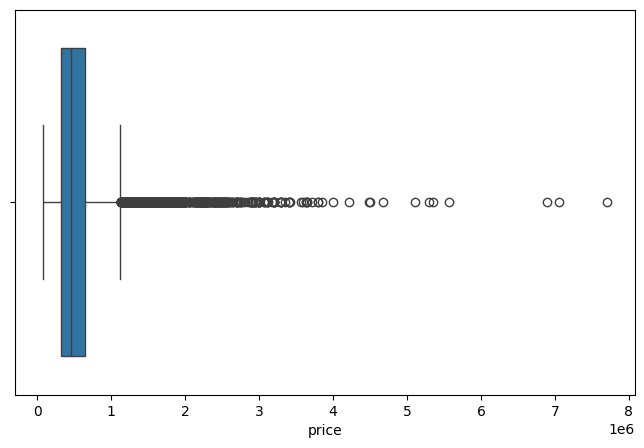

In [8]:
# Boxplot for price
sns.boxplot(x=df["price"])

In [9]:
# identiy outliers using IQR method
Q1 = df["price"].quantile(0.25)
Q3 = df["price"].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df["price"] < (Q1 - 1.5 * IQR)) |(df["price"] > (Q3 + 1.5 * IQR)))]
df['price'].describe()

count     20439.000
mean     476702.632
std      207790.276
min       78000.000
25%      315000.000
50%      437500.000
75%      600000.000
max     1120000.000
Name: price, dtype: float64

In [10]:
# Handle outliers for sqft_living
Q1 = df["sqft_living"].quantile(0.25)
Q3 = df["sqft_living"].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df["sqft_living"] < (Q1 - 1.5 * IQR)) |(df["sqft_living"] > (Q3 + 1.5 * IQR)))]
df["sqft_living"].describe()

count   20120.000
mean     1936.277
std       712.217
min       370.000
25%      1390.000
50%      1840.000
75%      2400.000
max      3970.000
Name: sqft_living, dtype: float64

### Handle Date data

In [11]:
df['yr_renovated'].value_counts()

yr_renovated
0.000        19503
20140.000       65
20130.000       29
20000.000       24
20070.000       24
             ...  
19530.000        1
19340.000        1
19510.000        1
19440.000        1
19540.000        1
Name: count, Length: 70, dtype: int64

In [12]:
df['yr_renovated'] = df['yr_renovated'].astype(str)
df['yr_renovated'] = df['yr_renovated'].str.strip('00.*')
df['yr_renovated'] = df['yr_renovated'].replace('.', np.nan)
df['yr_renovated'] = df['yr_renovated'].apply(lambda x: x + '0' if len(x) <= 3 else x)
df['yr_renovated'][df['yr_renovated'].str.len() < 4].value_counts()

yr_renovated
0     19503
20       24
Name: count, dtype: int64

In [13]:
# fix values of 200 to 2000
df['yr_renovated'] = df['yr_renovated'].replace('20', '2000')

In [14]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [15]:
df['yr_renovated'][0:10]

0        0
1     1991
2        0
3        0
4        0
6        0
7        0
8        0
9        0
10       0
Name: yr_renovated, dtype: object

In [16]:
df.duplicated().value_counts()

False    20120
Name: count, dtype: int64

### Handle categorial data

In [17]:
df['waterfront'] = df['waterfront'].astype('bool')
df['view'] = df['view'].astype('bool')
df[['condition','grade','zipcode']] = df[['condition','grade','zipcode']].astype('category')

### Univariant Analysis

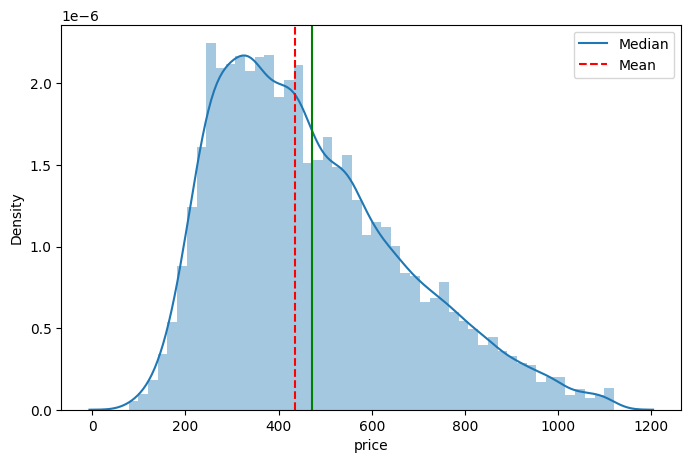

In [18]:
# Price distribution with median and mean

fig, ax = plt.subplots()
sns.distplot(df['price'], ax=ax)
ax.axvline(df['price'].median(), color='r', linestyle='--')
ax.axvline(df['price'].mean(), color='g', linestyle='-')
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x/1000)))
plt.legend({'Median':df['price'].median(),'Mean':df['price'].mean()})
plt.show()

After removing the outliers, we can see that the price is right skewed. The mean is 464,473.47 USD and the median is 434,450 USD
The standard deviation is 367,119 USD. The price ranges from 75,000 USD to 1,960,000 USD

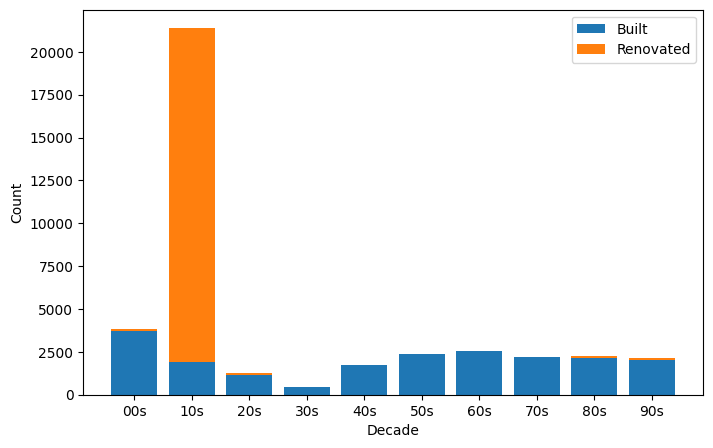

In [19]:
df['decade_build'] = df['yr_built'].apply(lambda x: str(x)[2:3] + '0s')
df['decade_build'] = df['decade_build'].astype('category')
decade = df['decade_build'].value_counts().sort_index()
df['decade_renovated'] = df['yr_renovated'].apply(lambda x: str(x)[2:3] + '0s' if x != 'nan' else x)
# stack bar plot for decade_build and decade_renovated
fig, ax = plt.subplots()
ax.bar(decade.index, decade.values)
ax.bar(decade.index, df['decade_renovated'].value_counts().sort_index().values, bottom=decade.values)
ax.set_xlabel('Decade')
ax.set_ylabel('Count')
ax.legend(['Built', 'Renovated'])
plt.show();

In [41]:
# Barplot by year renovated by percentage
df['renovated'] = df['yr_renovated'].apply(lambda x: 1 if x != 'nan' else 0)
df['renovated'].astype('bool')

0        True
1        True
2        True
3        True
4        True
         ... 
21592    True
21593    True
21594    True
21595    True
21596    True
Name: renovated, Length: 20120, dtype: bool

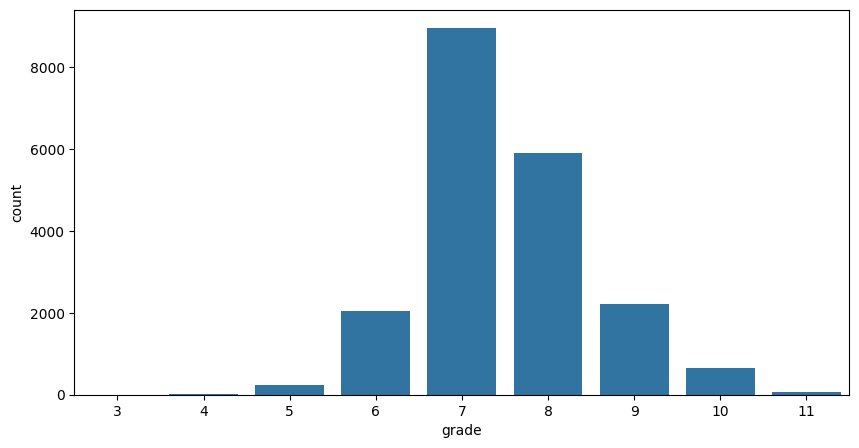

In [21]:
# Barplot grade
plt.figure(figsize=(10,5))
sns.countplot(x=df["grade"]);

<Axes: xlabel='condition', ylabel='count'>

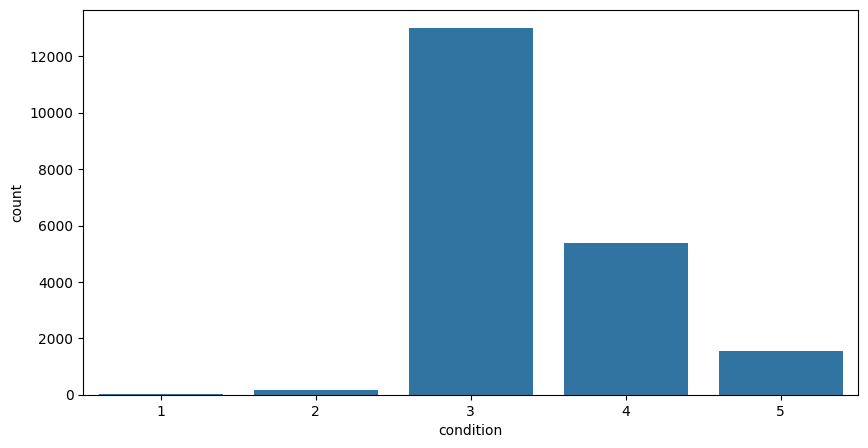

In [22]:
# barplot for condition
plt.figure(figsize=(10,5))
sns.countplot(x=df["condition"])

### Bi-variant analysis

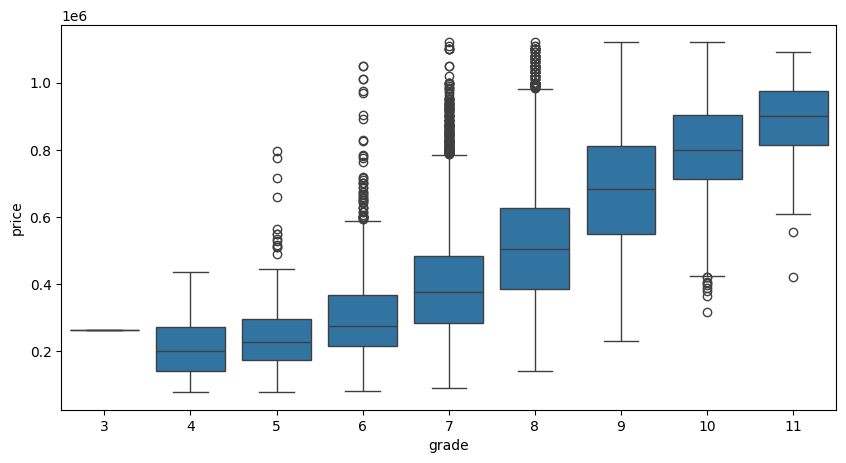

In [23]:
# Boxplot price vs grade
plt.figure(figsize=(10,5))
sns.boxplot(x=df["grade"], y=df["price"]);

<Axes: xlabel='condition', ylabel='price'>

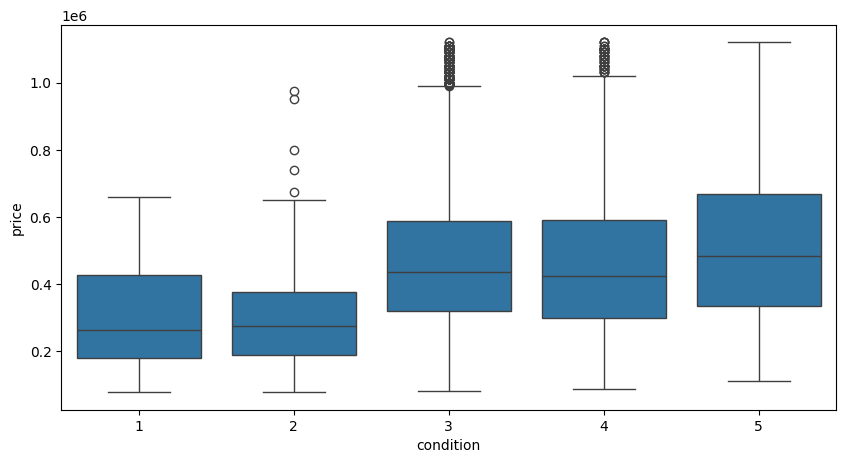

In [24]:
# Boxplot price vs condition
plt.figure(figsize=(10,5))
sns.boxplot(x=df["condition"], y=df["price"])

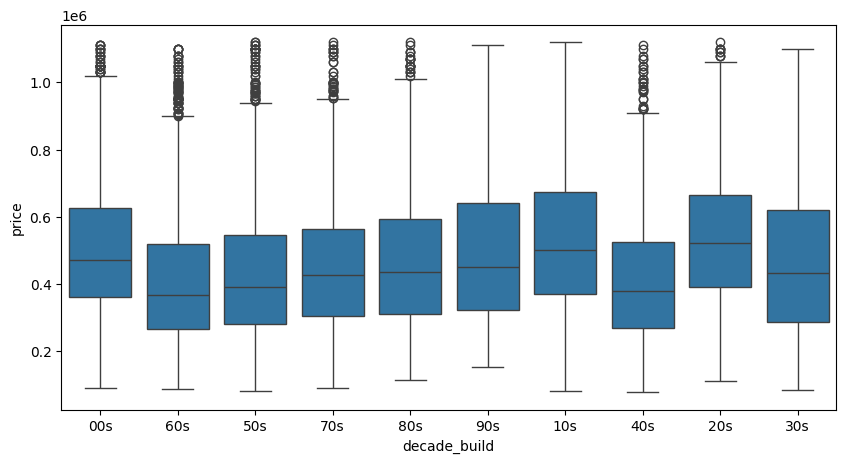

In [27]:
# Boxplot price vs yr_built by decade in ascending order
plt.figure(figsize=(10,5))
sns.boxplot(x=df["decade_build"], y=df["price"], order=df['decade_build'].value_counts().index);

The price of propeties depending on the year built seems to have a fluctuation trend. The price of properties built in first half of the century is the highest, while the price of properties built in in the second half seems to trend lower, up to last decade where prices are trending up.

In [28]:
# Create a new column for total sqft
df['sqft_total'] = df['sqft_living'] + df['sqft_lot'] + df['sqft_above'] + df['sqft_basement'] 

df['price_per_sqft'] = df['price']/df['sqft_total']

df['price_per_sqft'].describe()

count   20120.000
mean       44.588
std        29.074
min         0.163
25%        23.873
50%        37.401
75%        58.548
max       240.044
Name: price_per_sqft, dtype: float64

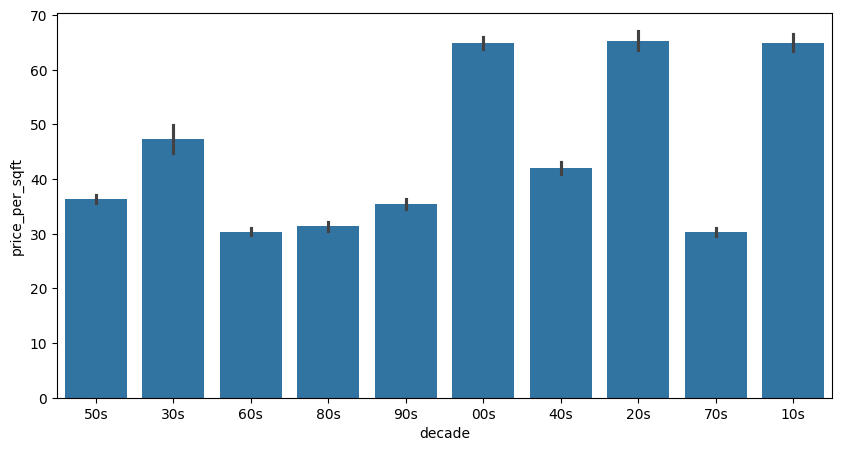

In [ ]:
# Plot decade vs mean price_per_sqft
plt.figure(figsize=(10,5))
sns.barplot(x=df["decade"], y=df["price_per_sqft"]);

In [ ]:
df[['bedrooms','sqft_living','floors','sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15']].describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,20120.000,3.313,0.898,1.000,3.000,3.000,4.000,33.000
sqft_living,20120.000,1936.277,712.217,370.000,1390.000,1840.000,2400.000,3970.000
floors,20120.000,1.469,0.536,1.000,1.000,1.000,2.000,3.500
sqft_lot,20120.000,13973.690,37764.171,520.000,5000.000,7481.500,10200.000,1651359.000
sqft_above,20120.000,1676.744,681.422,370.000,1170.000,1500.000,2060.000,3970.000
sqft_basement,20120.000,254.173,393.102,0.000,0.000,0.000,500.000,1990.000
sqft_living15,20120.000,1901.017,587.710,399.000,1460.000,1790.000,2250.000,4950.000
sqft_lot15,20120.000,12032.220,24895.108,651.000,5020.000,7500.000,9792.250,560617.000


<Axes: xlabel='price_per_sqft', ylabel='Density'>

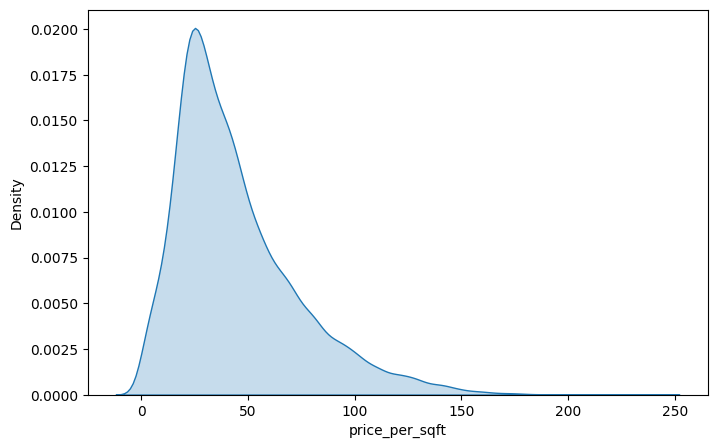

In [29]:
# scater plot for price per sqft
sns.kdeplot(df['price_per_sqft'], shade=True)

In [30]:
# Subset the data group by zipcode and price_per_sqft in ascending order
df_zipcode = df.groupby('zipcode')['price_per_sqft'].mean().sort_values(ascending=False).reset_index()

df_zipcode.head()

,zipcode,price_per_sqft
0,98102,118.519
1,98119,109.763
2,98109,109.570
3,98112,102.420
4,98107,97.543


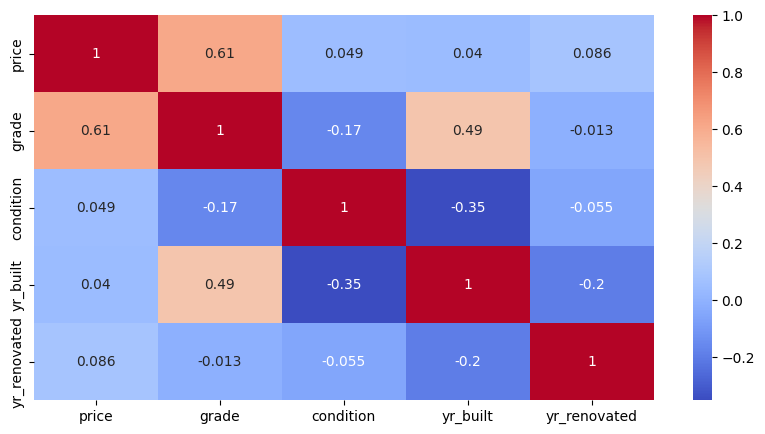

In [32]:
plt.figure(figsize=(10,5))
sns.heatmap(df[['price','grade','condition','yr_built','yr_renovated']].corr(), annot=True, cmap='coolwarm');

In [33]:

df_dimensions = df[['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_total','price_per_sqft','price']].sample(1000)

In [34]:
df_features = df[['bedrooms','bathrooms','floors','view','price']].sample(1000)
df_features.head()

,bedrooms,bathrooms,floors,view,price
9304,4.000,3.000,2.000,False,790000.000
12018,3.000,2.000,1.000,False,240000.000
3219,3.000,1.750,1.000,False,290000.000
14320,3.000,1.000,1.000,False,522000.000
10700,4.000,2.000,1.000,False,428000.000


In [49]:
# Average price, beedrooms, bathrooms, floors by zipcode
df_zipcode = df.groupby('zipcode')[['price','bedrooms','bathrooms','floors']].mean().reset_index()
df_zipcode.describe().T

,count,mean,std,min,25%,50%,75%,max
price,70.000,485071.969,163031.392,234284.035,344162.790,464798.525,593141.201,900833.333
bedrooms,70.000,3.303,0.241,2.774,3.131,3.321,3.453,3.816
bathrooms,70.000,2.012,0.240,1.417,1.839,2.005,2.150,2.607
floors,70.000,1.453,0.206,1.000,1.310,1.419,1.600,1.949


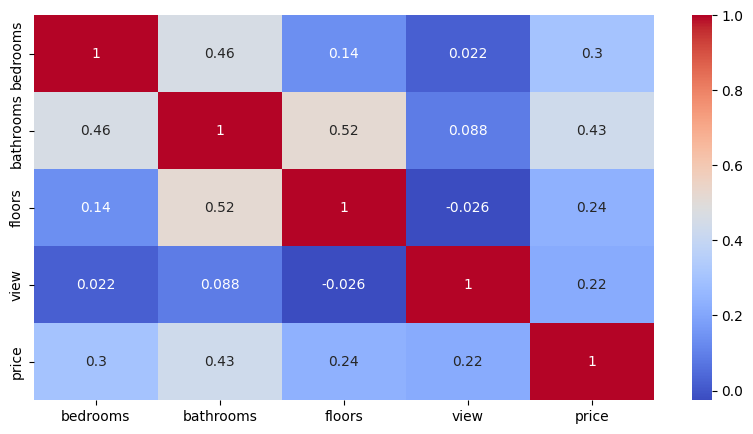

In [35]:
# correlation between features and price
plt.figure(figsize=(10,5))
sns.heatmap(df_features.corr(), annot=True, cmap='coolwarm');

In [47]:
df_features_corr = df_features.corr()['price'].sort_values(ascending=False)

df_features_corr.values[1:].mean()


0.24789027841666067

In terms of features amount of bathrooms can highly affect the price of the property. The more bathrooms the higher the price. The price of properties with 8 bathrooms is the highest, while the price of properties with 0.5 bathrooms is the lowest. Floors and Bedrooms also can determine the price of the property. The more floors and bedrooms the higher the price. The price of properties with 3 floors is the highest, while the price of properties with 1.5 floors is the lowest. The price of properties with 8 bedrooms is the highest, while the price of properties with 1 bedroom is the lowest.

In [39]:
df_time = df[['date', 'decade_build','yr_built','yr_renovated','price']]

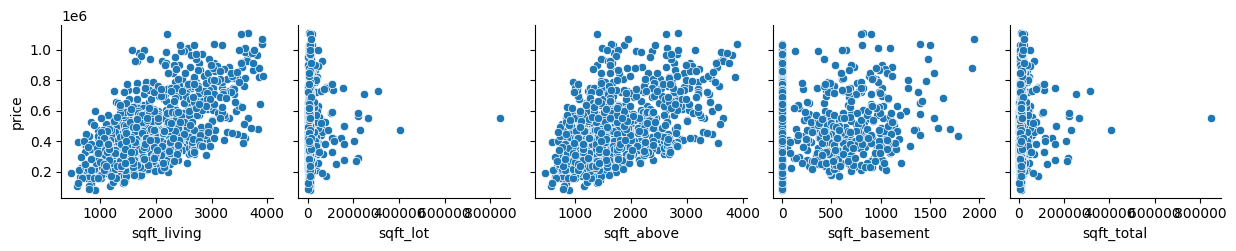

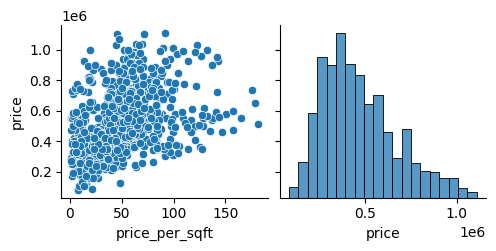

In [40]:
for i in range(0, len(df_dimensions.columns), 5):
    sns.pairplot(data=df_dimensions,
                x_vars=df_dimensions.columns[i:i+5],
                y_vars=['price'])

In [44]:
# In average how much the dimension determine the price
df_dimensions_corr = df_dimensions.corr()['price'].sort_values(ascending=False)

df_dimensions_corr.values[1:].mean()

0.3193107295955293

### Geo-spatial analysis


In [ ]:
# Load the map of King County
king_county = gpd.read_file('./data/king_county_map/Zipcodes_for_King_County_and_Surrounding_Area.shp')
king_county.head()


,OBJECTID,ZIP,ZIPCODE,COUNTY,ZIP_TYPE,COUNTY_NAM,PREFERRED_,Shape_Leng,Shape_Area,geometry
0,1,98001,98001,033,Standard,King County,AUBURN,147536.710,525368924.161,"POLYGON ((-122.29032 47.35495, -122.28851 47.3..."
1,2,98002,98002,033,Standard,King County,AUBURN,104440.087,205302754.220,"POLYGON ((-122.22820 47.35395, -122.22546 47.3..."
2,3,98003,98003,033,Standard,King County,FEDERAL WAY,123733.571,316942629.489,"POLYGON ((-122.30392 47.35794, -122.30393 47.3..."
3,4,98004,98004,033,Standard,King County,BELLEVUE,99325.952,250745415.523,"POLYGON ((-122.21189 47.64635, -122.21189 47.6..."
4,5,98005,98005,033,Standard,King County,BELLEVUE,116554.738,211433669.434,"MULTIPOLYGON (((-122.15354 47.66056, -122.1534..."


In [ ]:
#lowest price by zipcode
df_zipcode_lowest_price = df.groupby('zipcode')['price'].min().sort_values(ascending=False).reset_index()

In [ ]:
# Convert the 'ZIP' column to integers
king_county['ZIP'] = king_county['ZIP'].astype(int)

In [ ]:
# Merge the dataframes
king_county = king_county.merge(df, left_on='ZIP', right_on='zipcode', how='left')

In [ ]:
# subset the data by zipcode using df_zipcode
king_county = king_county[king_county['ZIP'].isin(df_zipcode_lowest_price['zipcode'])]


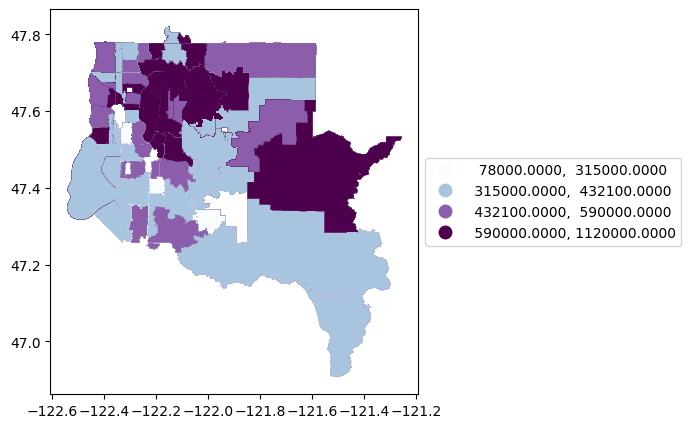

In [ ]:
# Plot the data
king_county.plot(
    column="price",
    scheme="QUANTILES",
    k=4,
    cmap="BuPu",
    legend=True,
    legend_kwds={"loc": "center left", "bbox_to_anchor": (1, 0.5), "fmt": "{:.4f}"},
);

In [ ]:
# plot with ipyleaflet
m = Map(center=(47.5, -122.2), zoom=9, basemap=basemaps.OpenStreetMap.Mapnik)

heatmaps = Heatmap(
    locations=df[['lat', 'long']].values.tolist(),
    z=df['price'].values.tolist(),
    radius=8,
    max=0.1
)

m.add_layer(basemap_to_tiles(basemaps.OpenStreetMap.BlackAndWhite))
m.add_layer(heatmaps)
m


Map(center=[47.5, -122.2], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

In [ ]:
#save the map
m.save('map.html')

In [ ]:
# Names of low price zipcodes
king_county[king_county['price'] < 400000]['PREFERRED_'].unique()

array(['AUBURN', 'FEDERAL WAY', 'BELLEVUE', 'BLACK DIAMOND', 'BOTHELL',
       'CARNATION', 'DUVALL', 'ENUMCLAW', 'FALL CITY', 'ISSAQUAH',
       'KENMORE', 'KENT', 'KIRKLAND', 'MAPLE VALLEY', 'NORTH BEND',
       'REDMOND', 'RENTON', 'SNOQUALMIE', 'VASHON', 'WOODINVILLE',
       'SAMMAMISH', 'SEATTLE'], dtype=object)